In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
from scipy.ndimage import gaussian_filter

In [2]:
# to prepare the training data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cuda:1')
print(device)

cuda


In [4]:
from torch.utils.data import Dataset, DataLoader
transform = transforms.Compose(
        [
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ]
    )

In [5]:
import numpy as np
import cv2

def find_circle(img):
    # img is 2D
#     img = 255*(img/np.max(img))
#     img = np.dstack((img, img, img))
#     img = img.astype(np.uint8)
    gray_image=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    output=img.copy()
    circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, 1.3, 100, param1=100, param2=40, minRadius=40, maxRadius=70)
    if circles is not None:
         circles = np.round(circles[0, :]).astype("int")
         for (x, y, r) in circles:
             cv2.circle(output, (x, y), r, (0, 255, 0), 2)
             print(x,y,r)
    #plt.imshow(output)
    return circles

In [6]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input    

In [7]:
model_name = 'DenseNet'

In [8]:
import sys  
sys.path.insert(0, '/home/muller_group/Documents/STEMalign-main/CNNtraining')
from VGG16 import Net

if model_name == 'VGG':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', pretrained=True)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 1)
    model.load_state_dict(torch.load('/home/muller_group/Documents/STEMalign-main/CNNtraining/trained_models/VGG16bn_25000_aperture0.pt'))
    model.eval()

elif model_name == 'DenseNet':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 1)
    model.load_state_dict(torch.load('/home/muller_group/Documents/STEMalign-main/CNNtraining/trained_models/Densenet_25000_aperture0.pt'))
    model.eval()
    
if torch.cuda.is_available():
    model.to('cuda')
model.eval()

Using cache found in /home/muller_group/.cache/torch/hub/pytorch_vision_v0.10.0
/home/muller_group/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/muller_group/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Testing on Kraken

In [9]:
parameter = 'stig'
scan_xy = 'scanx'

In [10]:
linescan_folder = '/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/300kv_laceyCarbon/linescan/' + parameter + '/'
ronch_linescan = glob.glob(linescan_folder + '*' + scan_xy +'*ronch*')
X_linescan = glob.glob(linescan_folder + '*' + scan_xy + '*X*')

# linescan_folder = '/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/300kv_laceyCarbon/linescan/' + parameter + '/'
# ronch_linescan = glob.glob(linescan_folder +'*ronch*')
# X_linescan = glob.glob(linescan_folder + '*X*')

In [11]:
ronch_linescan

['/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/300kv_laceyCarbon/linescan/stig/stig_linescan_scanx_return_rep0__ronch.npy',
 '/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/300kv_laceyCarbon/linescan/stig/stig_linescan_scanx_return_rep5__ronch.npy',
 '/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/300kv_laceyCarbon/linescan/stig/stig_linescan_scanx_return_rep3__ronch.npy',
 '/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/300kv_laceyCarbon/linescan/stig/stig_linescan_scanx_return_rep4__ronch.npy',
 '/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/300kv_laceyCarbon/linescan/stig/stig_linescan_scanx_return_rep2__ronch.npy',
 '/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/300kv_laceyCarbon/linescan/stig/stig_linescan_scanx_return_rep1__ronch.npy']

In [12]:
# for index in range(100):
#     img = ronch[index, :, :].astype('float')
#     img = scale_range(img, 0, 1)
#     img_nparray = np.dstack((img, img, img))
#     print(index)
#     find_circle(np.uint8(img_nparray * 255))
#     if find_circle(np.uint8(img_nparray * 255)) is None:
#         print(index)
#         break

In [16]:
class RonchigramDataset(Dataset):
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index, :, :].astype('float')
        img = scale_range(img, 0.05, 1.0)
        img = scale_range(img, 0, 1)
        new_channel = np.zeros(img.shape)
        img_nparray = np.dstack((img, new_channel, new_channel))
        img = Image.fromarray(np.uint8(img_nparray * 255))
        
        if self.transform is not None:
            #xyr = [[263,253,55]]
            xyr = find_circle(np.uint8(img_nparray * 255))
            if xyr is None:
                xyr = [[263,250,55]]
            img = torchvision.transforms.functional.crop(img,xyr[0][1]-(4/3)*xyr[0][2],xyr[0][0]-(4/3)*xyr[0][2],2*(4/3)*xyr[0][2],2*(4/3)*xyr[0][2])
            img = self.transform(img)

        return (img)


# class RonchigramDataset(Dataset):
#     def __init__(self, data, transform = None):
#         self.data = data
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         img = self.data[index, :, :].astype('float')
#         img = scale_range(img, 0.05, 1.0)
#         img = scale_range(img, 0, 1)
#         new_channel = np.zeros(img.shape)
#         img = np.dstack((img, new_channel, new_channel))
#         img = Image.fromarray(np.uint8(img * 255))
        
#         if self.transform is not None:
#             img = torchvision.transforms.functional.crop(img,176.6,189.6,146.6,146.6)
#             img = self.transform(img)

#         return (img)

In [96]:
frame[0].unsqueeze(0).shape

torch.Size([1, 3, 128, 128])

In [103]:
pred_emit_rep = []
for i in range(len(ronch_linescan)):
    # ronch = np.load(filelist_stig_linescan_folder[0] + parameter + '_linescan__ronch.npy')
    ronch = np.load(ronch_linescan[i])
    X = np.load(X_linescan[i])
#     ronch = crop_center(ronch,crop_size,crop_size)
    # X = np.load(filelist_stig_linescan_folder[i] + parameter + '_linescan__X.npy')
    dataset = RonchigramDataset(ronch, transform = transform)
    
    device = 'cuda:0'
    linescan_pred = []
    frame = torch.tensor([])
    for j in range(len(ronch)):    
        frame = torch.cat([frame, (dataset.__getitem__(j)).unsqueeze(0)])
        prediction = model(frame[j].unsqueeze(0).float().contiguous().to(device))
        linescan_pred.append(prediction.item())
    pred_emit_rep.append(np.array(linescan_pred))
    #     print(prediction.item())

263 261 56
263 258 53
262 263 55
263 259 55
262 258 53
263 262 55
263 262 56
265 262 56
263 262 56
263 261 56
263 261 56
263 261 56
263 259 54
263 262 56
263 259 54
263 262 56
263 262 55
265 262 56
263 262 55
263 261 56
263 261 56
262 262 56
262 261 56
262 261 56
263 261 56
262 262 56
263 261 56
263 261 56
263 261 56
265 262 56
263 261 56
263 262 55
263 261 56
263 259 54
263 261 56
263 262 56
263 261 56
265 262 56
265 262 56
263 261 56
262 262 56
262 262 56
265 262 56
265 261 56
263 262 55
263 261 56
263 262 55
263 261 56
263 262 56
262 261 56
263 262 56
262 259 54
263 262 56
263 261 56
262 261 56
265 262 56
263 262 56
263 262 55
263 262 56
262 262 56
263 259 54
263 262 55
265 262 56
263 262 55
263 261 56
262 262 56
262 262 56
263 261 56
262 261 56
263 261 56
263 262 56
263 262 55
262 261 56
265 262 56
265 261 56
263 262 56
263 263 55
262 261 56
263 262 55
262 262 56
262 262 56
265 262 56
265 261 56
263 261 56
263 262 55
265 262 56
262 262 56
263 261 56
263 261 56
263 261 56
262 261 56

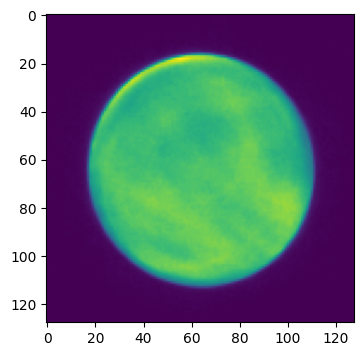

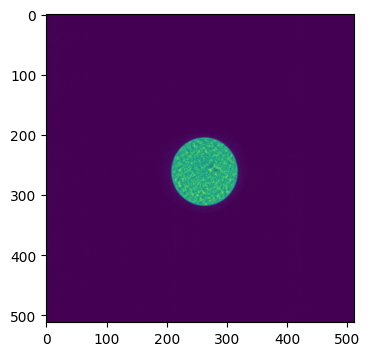

In [104]:
fig, ax = plt.subplots( figsize = [5, 4])
ax.imshow(frame[0,0,:])
fig, ax = plt.subplots( figsize = [5, 4])
ax.imshow(ronch[99,:])

In [105]:
frame[0,0,:]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [106]:
np.save(linescan_folder + parameter + '_' + scan_xy + '_pred_emit_rep_DensenetAll.npy', pred_emit_rep)

In [107]:
pred_emit_rep = np.load(linescan_folder + parameter + '_' + scan_xy + '_pred_emit_rep_DensenetAll.npy' )
avg_linescan = np.mean(pred_emit_rep, axis = 0)
std_linescan = np.std(pred_emit_rep, axis = 0)
ci_linescan = (1.96/np.sqrt(5))*std_linescan

order = np.argsort(X.squeeze())
X_sorted = X.squeeze()[order]
avg_sorted = avg_linescan[order]
std_sorted = std_linescan[order]
ci_sorted = ci_linescan[order]

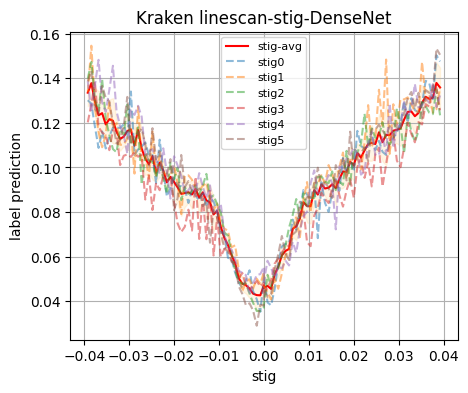

In [108]:
fig, ax = plt.subplots( figsize = [5, 4])
ax.plot(X_sorted, avg_sorted, label = parameter + '-avg', color = 'red')
for i in range(len(ronch_linescan)):
    idx = '%d' %i
    ax.plot(X_sorted, pred_emit_rep[i][order], label = parameter + idx, linestyle='--', alpha = 0.5)

# ax.plot(X_sorted, pred_emit_rep[3][order], label = 'stigx-4', linestyle='--', alpha = 0.5)
ax.fill_between(X_sorted, (avg_sorted-ci_sorted), (avg_sorted+ci_sorted), color ='orange', alpha=.1)
ax.set_title('Kraken linescan-'+parameter+ '-' +model_name)
ax.set_ylabel('label prediction')
ax.set_xlabel(parameter)
ax.legend(loc='upper center', ncol=1, fontsize = 8)
# plt.ylim(0.02, 0.12)
# plt.xlim(-1e-4*210, 1e-4*210)
# plt.xlim(-1e-7, 2e-7)
# plt.ylim(0.02, 0.15)
plt.grid()
# savepath = '/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20221130/%s_kraken_linescan_%s.png' %(model_name, parameter) 
#fig.savefig(savepath, format='png', dpi = 300)

# Plot

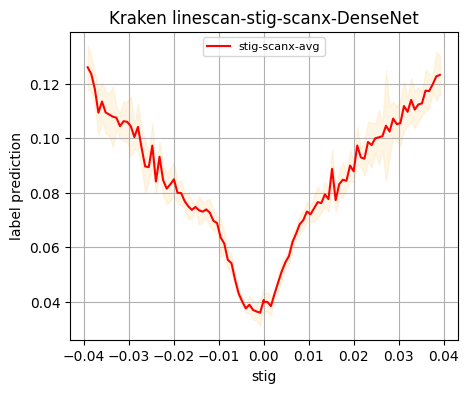

In [158]:
avg_linescan = np.mean(pred_emit_rep, axis = 0)
std_linescan = np.std(pred_emit_rep, axis = 0)
ci_linescan = (1.96/np.sqrt(5))*std_linescan

order = np.argsort(X.squeeze())
X_sorted = X.squeeze()[order]
avg_sorted = avg_linescan[order]
std_sorted = std_linescan[order]
ci_sorted = ci_linescan[order]

fig, ax = plt.subplots( figsize = [5, 4])
ax.plot(X_sorted, avg_sorted, label = parameter + '-' + scan_xy+'-avg', color = 'red')
# for i in range(len(pred_emit_rep)):
#     idx = '%d' %i
#     ax.plot(X_sorted, pred_emit_rep[i][order], label = parameter + idx, linestyle='--', alpha = 0.5)

# ax.plot(X_sorted, pred_emit_rep[3][order], label = 'stigx-4', linestyle='--', alpha = 0.5)
ax.fill_between(X_sorted, (avg_sorted-ci_sorted), (avg_sorted+ci_sorted), color ='orange', alpha=.1)
ax.set_title('Kraken linescan-'+parameter+ '-' + scan_xy +'-'+model_name)
ax.set_ylabel('label prediction')
ax.set_xlabel(parameter)
ax.legend(loc='upper center', ncol=1, fontsize = 8)
# plt.ylim(0.02, 0.12)
# plt.xlim(-1e-4*210, 1e-4*210)
# plt.xlim(-1e-7, 2e-7)
# plt.ylim(0.02, 0.15)
plt.grid()
# savepath = '/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20221130/%s_kraken_linescan_%s.png' %(model_name, parameter) 
# fig.savefig(savepath, format='png', dpi = 300)

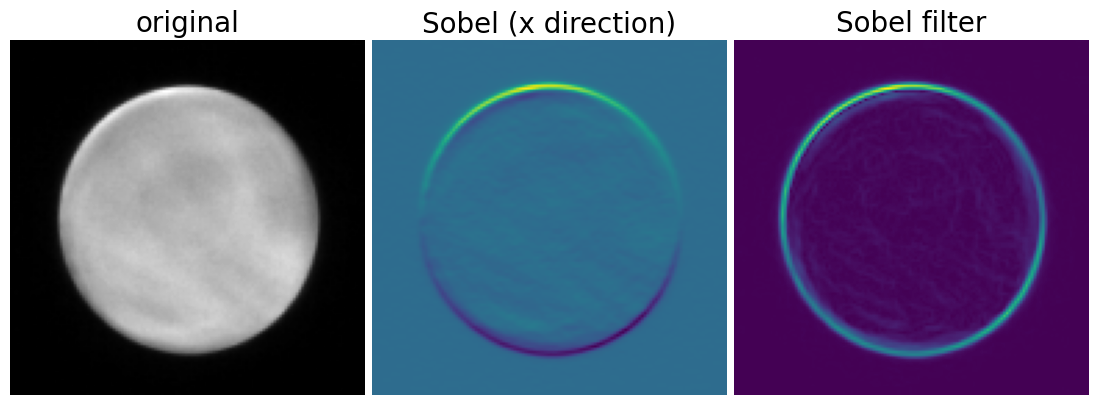

In [133]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# im = np.zeros((256, 256))
# im[64:-64, 64:-64] = 1

# im = ndimage.rotate(im, 15, mode='constant')
# im = ndimage.gaussian_filter(im, 8)
im = frame[0,0,:]

sx = ndimage.sobel(im, axis=0, mode='constant')
sy = ndimage.sobel(im, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.figure(figsize=(16, 5))
plt.subplot(141)
plt.imshow(im, cmap=plt.cm.gray)
plt.axis('off')
plt.title('original', fontsize=20)
plt.subplot(142)
plt.imshow(sx)
plt.axis('off')
plt.title('Sobel (x direction)', fontsize=20)
plt.subplot(143)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel filter', fontsize=20)

# im += 0.07*np.random.random(im.shape)

# sx = ndimage.sobel(im, axis=0, mode='constant')
# sy = ndimage.sobel(im, axis=1, mode='constant')
# sob = np.hypot(sx, sy)

# plt.subplot(144)
# plt.imshow(sob)
# plt.axis('off')
# plt.title('Sobel for noisy image', fontsize=20)



plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=0.9)

plt.show()

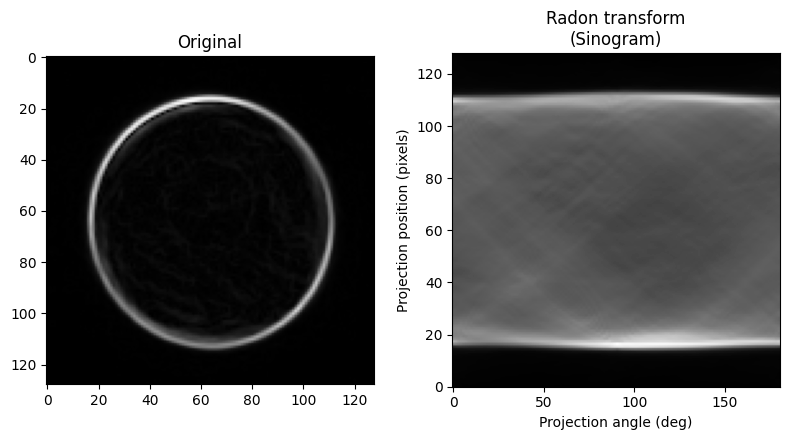

In [134]:
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

# image = shepp_logan_phantom()
# image = frame[6,0,:]
image = sob
image = rescale(image, scale= 1.0 , mode='reflect', channel_axis=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
plt.ylim([0,128])

fig.tight_layout()
plt.show()